In [4]:
#importing all packages and functions that will be necesearry 
import pandas as pd
import functions as fc
from tqdm import tqdm
import networkx as nx
from sklearn.metrics import accuracy_score, confusion_matrix

# Prediction 

In [5]:
#from the raw data we creat a DF for edges and nodes
# the function cleared and filtered it for the relevant profiles 
nodes, edges = fc.load_and_select_profiles_and_edges()

loading profiles
loading edges
1    2642113
2    1992414
Name: source, dtype: int64
Selected profiles: 695406
Nodes with edges: 434590


,user_id,public,gender,region,AGE,TRAIN_TEST
0,1,1,1.0,"zilinsky kraj, zilina",26.0,TRAIN
4,4,1,0.0,"banskobystricky kraj, brezno",26.0,TRAIN
5,17,1,0.0,"zilinsky kraj, martin",27.0,TRAIN
6,5,1,1.0,"zilinsky kraj, zilina",26.0,TRAIN
7,18,1,1.0,"zilinsky kraj, kysucke nove mesto",18.0,TRAIN


In [7]:
#spillting the nodes database for TEST and TRAIN DFs for estimation the selection already happened above

nodes_test, nodes_train = [x for _, x in nodes.groupby(nodes['TRAIN_TEST'] == 'TRAIN')]

# Creating graphs from the new datasets 

G_test = fc.create_graph_from_nodes_and_edges(nodes_test, edges)
G_train = fc.create_graph_from_nodes_and_edges(nodes_train, edges)

# With the graphs we try to predict the missing genders in the test graph by counting the gender of the neighbours
# if a node has more male neighbours then it is probably a male and reverse 
# the prediction is done with iteration 

pred_gend = []
for userid in tqdm(nodes_test.user_id):
    neighbors_it = set(G_train.neighbors(userid))
    genders = nodes_train[nodes_train.user_id.isin(neighbors_it)].dropna() \
        .groupby('gender').count()
    try:
        males = genders.loc[1, 'user_id']
    except:
        males = 0
    try:
        females = genders.loc[0, 'user_id']
    except:
        females = 0

    if males >= females:
        pred_gend.append(1)
    else:
        pred_gend.append(0)
    

prediction = pd.DataFrame(dict(user_id = nodes_test.user_id, gender = pred_gend))


100%|██████████| 40000/40000 [07:00<00:00, 95.02it/s] 


In [19]:
#we now append the results with the train dataframe so we have an almost complete dataset so we can begin the visualization

nodes_test['gender']=prediction['gender']

pred_nodes=nodes_test.append(nodes_train)

pred_nodes

,user_id,public,gender,region,AGE,TRAIN_TEST
65,80,1,1.0,"zahranicie, zahranicie - ostatne",NaN,TEST
116,140,1,0.0,"zilinsky kraj, kysucke nove mesto",NaN,TEST
178,229,1,0.0,"banskobystricky kraj, brezno",NaN,TEST
185,272,1,0.0,"zilinsky kraj, cadca",NaN,TEST
200,259,1,1.0,"zilinsky kraj, cadca",NaN,TEST
...,...,...,...,...,...,...
1632744,1632745,1,0.0,"presovsky kraj, humenne",50.0,TRAIN
1632752,1632753,1,0.0,"ceska republika, cz - ustecky kraj",37.0,TRAIN
1632782,1632783,1,1.0,"trenciansky kraj, povazska bystrica",37.0,TRAIN
1632784,1632785,1,1.0,"trenciansky kraj, povazska bystrica",37.0,TRAIN


In [ ]:
#Due to shortage of time and coding skill i was unable to do the prediction with triads

# Visualization

In [20]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [22]:

G= fc.create_graph_from_nodes_and_edges(pred_nodes, edges)


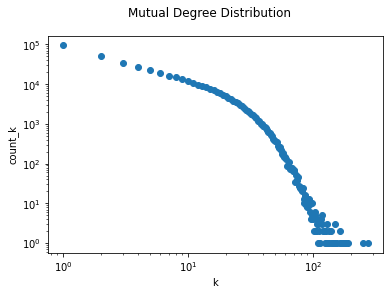

In [23]:
fc.plot_degree_distribution(G)

From the Degree Disstribution we can surely assume that it is not scale-free beacuse of the visible break.

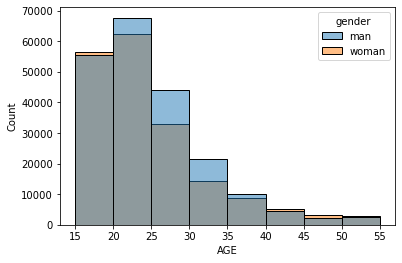

In [24]:
fc.plot_age_distribution_by_gender(pred_nodes)

The other easily computable distribution is the gender one. 
With the increasing age the are far less representatives in the dataset in each gender.
Males are generally more active in their middle ages, while females tend to more active in their young and old ages.


In [32]:
#Adding connectivity and triclosure to not just visualize the degree by gender

pred_nodes['connectivity']=pred_nodes.user_id.map(nx.average_neighbor_degree(G))
pred_nodes['triclo']= pred_nodes.user_id.map(nx.clustering(G))

pred_nodes


,user_id,public,gender,region,AGE,TRAIN_TEST,connectivity,triclo
65,80,1,1.0,"zahranicie, zahranicie - ostatne",NaN,TEST,17.722222,0.039216
116,140,1,0.0,"zilinsky kraj, kysucke nove mesto",NaN,TEST,22.166667,0.071895
178,229,1,0.0,"banskobystricky kraj, brezno",NaN,TEST,29.600000,0.060504
185,272,1,0.0,"zilinsky kraj, cadca",NaN,TEST,19.571429,0.190476
200,259,1,1.0,"zilinsky kraj, cadca",NaN,TEST,20.300000,0.111111
...,...,...,...,...,...,...,...,...
1632744,1632745,1,0.0,"presovsky kraj, humenne",50.0,TRAIN,1.000000,0.000000
1632752,1632753,1,0.0,"ceska republika, cz - ustecky kraj",37.0,TRAIN,3.000000,0.000000
1632782,1632783,1,1.0,"trenciansky kraj, povazska bystrica",37.0,TRAIN,1.000000,0.000000
1632784,1632785,1,1.0,"trenciansky kraj, povazska bystrica",37.0,TRAIN,1.000000,0.000000


In [37]:
# We can check different node level statistics by gender like connectivity  
def plot_node_stats_by_gender(nodes, G, kind):
    """Plot the average of node degree across age and gender"""

    nodes_w_degree = nodes.set_index("user_id").merge(
        pd.Series(dict(G.degree)).to_frame(),
        how="left",
        left_index=True,
        right_index=True,
    )
    nodes_w_degree = nodes_w_degree.rename({0: "degree"}, axis=1)
    plot_df = (
        nodes_w_degree.groupby(["AGE", "gender"]).agg({"degree": "mean"}).reset_index()
    )
    
    if kind == "degree":
        sns.lineplot(data=plot_df, x="AGE", y="degree", hue="gender")
    elif kind == "connectivity":
        sns.lineplot(data=pred_nodes, x="AGE", y="connectivity", hue="gender")
    elif kind =="tri":
        sns.lineplot(data=pred_nodes, x="AGE", y="triclo", hue="gender")

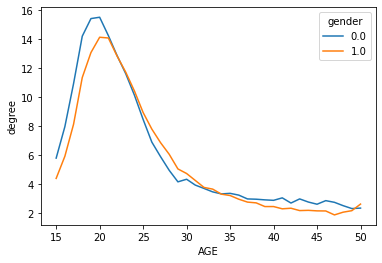

In [38]:
plot_node_stats_by_gender(pred_nodes, G, 'degree')

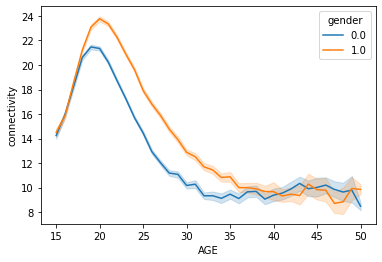

In [39]:
plot_node_stats_by_gender(pred_nodes, G, 'connectivity')

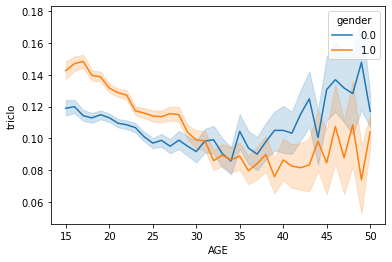

In [41]:
plot_node_stats_by_gender(pred_nodes, G, 'tri')

I try to show some other node level statistics not just the 'degree plot'.

In terms of degree centrality there is not a significant deference between the genders. But that is true for most of the research made. It peaks around the start of adulthood and starting to fade away. But that is not a suprise, we could have easily foresee this at the age distribution plot. Most of the data consist young adults so it is natural that they have the highest avarge node degree. 

The connectivity graph is similar if not almost the same as the degree graph. The reasons are not differenct either. On the other hand we could see the same thing in the articel. The reason behind this is natural. The young adults have the widest range of connections. They meet different peoples from the high school, uni, workplace and the childhood friends are also around, so basically thats the most generally the most hectic period in terms of communication.

Clustering coefficient is constantly increasing from the age of 30. But the differences are not that large with the increasing age (+_ 0.4). Due to the lack of eldery in the dataset it is hard to make conclusions towards later ages. 

In [46]:
#Edge distribution realitions of age (i was unable to filter by gender)

def plot_age_relations_heatmap(edges_w_features,how):
    """Plot a heatmap that represents the distribution of edges"""

    plot_df = edges_w_features.groupby(["gender_x", "gender_y", "AGE_x", "AGE_y"]).agg(
        {"smaller_id": "count"}
    )
    plot_df_w_w = plot_df.loc[(0, 0)].reset_index()
    plot_df_heatmap = plot_df_w_w.pivot_table(
        index="AGE_x", columns="AGE_y", values="smaller_id"
    ).fillna(0)
    plot_df_heatmap_logged = np.log(plot_df_heatmap + 1)
    
    if how=="nonlog":
        sns.heatmap(plot_df_heatmap)
    else:
        sns.heatmap(plot_df_heatmap_logged)
    
    
    

In [50]:
edges_w_features = fc.add_node_features_to_edges(pred_nodes, edges)

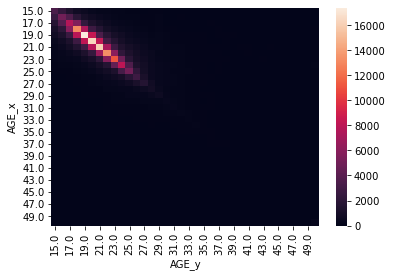

In [51]:
plot_age_relations_heatmap(edges_w_features,"nonlog")

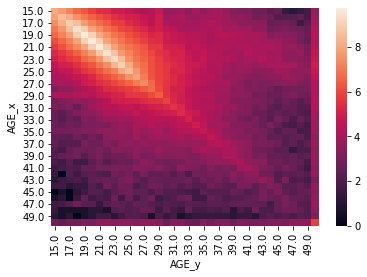

In [53]:
plot_age_relations_heatmap(edges_w_features,"")

(If we do not log the values in the heatmap, we could only see the highest intensity spots beacaouse of the large differences. It can be useful but only in some niche situations.)

The heatmap also supports our assumptions, that the structure of dataset really effects our research. We can not assume that the heatmap would be the same with more ageing people in the dataset.
But we can make some conclusions regardless. 
People generally communicates most with the same age group as themselves. We can easily see the white line in the middle of the graph. 
Young people generally befriends more people from different age groups, but mostly middle aged people (15-29).
We can see higher a bit higher intensity beetween the youngest and the oldest age group. Thats mainly due the grandchild-grandparent connections.


